# Problem Statement: IMDB Comment Sentiment Classifier

Dataset: For this exercise we will use a dataset hosted at http://ai.stanford.edu/~amaas/data/sentiment/

**Problem Statement**: 
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

Launch a spark session, verify the spark session UI

In [1]:
# Note: set SPARK_HOME to Spark binaries before launching the Jupyter session.
import os, sys
SPARK_HOME = os.environ['SPARK_HOME']
sys.path.insert(0, os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.4-src.zip"))
sys.path.insert(0, os.path.join(SPARK_HOME, "python"))

from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .appName("SparkML-ImageClf")\
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory", "4g")\
    .getOrCreate()
print("Spark version: ", spark.version)

24/10/31 01:24:28 WARN Utils: Your hostname, long-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/10/31 01:24:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/31 01:24:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version:  3.5.3


In [2]:
spark.sparkContext.uiWebUrl

'http://10.0.2.15:4040'

IMDB comments dataset has been stored in the following location 

In [7]:
!wc -l ./data/imdb-comments.json

50000 ./data/imdb-comments.json


There are 50000 lines in the file. Let's the first line

In [9]:
!du -sh ./data/imdb-comments.json

67M	./data/imdb-comments.json


Total size of the file is 66MB

In [11]:
!head -n 1 ./data/imdb-comments.json

{"label": "train", "sentiment": "pos", "name": "9661_8.txt", "content": "After losing the Emmy for her performance as Mama Rose in the television version of GYPSY, Bette won an Emmy the following year for BETTE MIDLER: DIVA LAS VEGAS, a live concert special filmed for HBO from Las Vegas. Midler, who has been performing live on stage since the 1970's, proves that she is still one of the most electrifying live performers in the business. From her opening number, her classic \"Friends\", where she descends from the wings atop a beautiful prop cloud, Bette commands the stage with style and charisma from a rap-styled number called \"I Look Good\" she then proves that she has a way with a joke like few other performers in this business as she segues her way through a variety of musical selections. The section of the show where she salutes burlesque goes on a little too long but she does manage to incorporate her old Sophie Tucker jokes here to good advantage (even though she actually forgets

Each line is a self contained json doc. Load the dataset using spark reader specifying the file format as json. As we see above size of the file is 66 MB, we should at least 2 partitons, since I am using dual core system, I will repartition the data to 4. Also will cache the data after repartitioning.

In [12]:
imdb = spark.read.format("json").load("./data/imdb-comments.json").repartition(4).cache()

Find total number of records

In [13]:
print('Long: 22022604')
imdb.count()

Long: 22022604


50000

Print Schema and view the field types

In [14]:
print('Long: 22022604')
imdb.printSchema()

Long: 22022604
root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)



Take a look at a few sample data

In [15]:
print('Long: 22022604')
imdb.show()

Long: 22022604
+--------------------+-----+-----------+---------+
|             content|label|       name|sentiment|
+--------------------+-----+-----------+---------+
|Pakeezah is in my...|train|3303_10.txt|      pos|
|This is a really ...|train|7951_10.txt|      pos|
|I am always wary ...|train| 6209_4.txt|      neg|
|I discovered this...|train| 3410_9.txt|      pos|
|It's remarkable a...|train| 9575_9.txt|      pos|
|CAROL'S JOURNEY i...|train|5341_10.txt|      pos|
|Considered by alm...|train|11288_8.txt|      pos|
|Had never heard o...|train|2306_10.txt|      pos|
|I got this movie ...|train| 2517_9.txt|      pos|
|This movie has be...|train| 3875_9.txt|      pos|
|This movie has it...|train| 9774_8.txt|      pos|
|This movie has re...|train| 9189_1.txt|      neg|
|Alexandr "Sascha"...|train|  484_8.txt|      pos|
|Put quite simply,...|train|3286_10.txt|      pos|
|An unusual take o...|train| 5163_7.txt|      pos|
|Peaches is truly ...|train|9782_10.txt|      pos|
|This has just b

*label* - column indicate whethet the data belong to training or test bucket.
*sentiment* - column indicates whether the comment carries positive or negative sentiment. This column has been manually curated.

Find out for each combination of label and sentimnet how many records are there.

In [16]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [17]:
print('Long: 22022604')
imdb.groupBy("sentiment").pivot("label").count().show()

Long: 22022604
+---------+-----+-----+
|sentiment| test|train|
+---------+-----+-----+
|      pos|12500|12500|
|      neg|12500|12500|
+---------+-----+-----+



Look at a sample comment value

In [18]:
print('Long: 22022604')
content = imdb.sample(False, 0.001, 1).first().content
content

Long: 22022604


'How can anyone argue the fact that Urban Cowboy was, and still is, the best document of Texas life for the time period. Consider the following: men beat their wives, get drunk at bars nightly, get married to settle a fight, commit adultery, and compete on mechanical bulls. Try and name a movie that depicts real life so vividly. They dont make them anymore. It seems current films are always about people with lots of money, they live in huge homes, drive expensive cars and don\'t work. This movie has a celebration scene about getting a trailer for pete\'s sake !<br /><br />Anyway, I watch it at least once a week. No kidding. I have dissected this movie from end to end. feel free to email me to learn more about my reason for calling it a documentary. Consider the following scenes: Bud sees Sissy - they are split up - he amicably honks and waves, she flips him the bird - he returns half the peace sign honking his horn to add impact then tears off.<br /><br />Buds mom calls him approx. 18 

Register a UDF function to clean the comment from the html tags. If BeautifulSoup is not installed, you can install it using pip 

```(shell command)
$ pip install BeautifulSoup4
```

In [ ]:
from bs4 import BeautifulSoup
from pyspark.sql.types import * 
import re
def remove_html_tags(text):
    text = BeautifulSoup(text, "html.parser").text.lower() #removed html tags
    text = re.sub(r"[\W]+", " ", text)
    return text

spark.udf.register("remove_html_tags", remove_html_tags, StringType())

24/10/31 01:43:35 WARN SimpleFunctionRegistry: The function remove_html_tags replaced a previously registered function.


<function __main__.remove_html_tags(text)>

Test the remove_html_tags function

In [31]:
print('Long: 22022604')
remove_html_tags(content)

Long: 22022604


'how can anyone argue the fact that urban cowboy was and still is the best document of texas life for the time period consider the following men beat their wives get drunk at bars nightly get married to settle a fight commit adultery and compete on mechanical bulls try and name a movie that depicts real life so vividly they dont make them anymore it seems current films are always about people with lots of money they live in huge homes drive expensive cars and don t work this movie has a celebration scene about getting a trailer for pete s sake anyway i watch it at least once a week no kidding i have dissected this movie from end to end feel free to email me to learn more about my reason for calling it a documentary consider the following scenes bud sees sissy they are split up he amicably honks and waves she flips him the bird he returns half the peace sign honking his horn to add impact then tears off buds mom calls him approx 18 hours after he gets into town on a sunday to see if he 

Apply the the udf on the imdb dataframe.

In [32]:
print('Long: 22022604')
imdb_clean = imdb.withColumn("content", expr("remove_html_tags(content)")).cache()
imdb_clean.sample(False, 0.001, 1).first().content

Long: 22022604


/tmp/ipykernel_24569/2569747742.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/tmp/ipykernel_24569/2569747742.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/tmp/ipykernel_24569/2569747742.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/tmp/ipykernel_24569/2569747742.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


'how can anyone argue the fact that urban cowboy was and still is the best document of texas life for the time period consider the following men beat their wives get drunk at bars nightly get married to settle a fight commit adultery and compete on mechanical bulls try and name a movie that depicts real life so vividly they dont make them anymore it seems current films are always about people with lots of money they live in huge homes drive expensive cars and don t work this movie has a celebration scene about getting a trailer for pete s sake anyway i watch it at least once a week no kidding i have dissected this movie from end to end feel free to email me to learn more about my reason for calling it a documentary consider the following scenes bud sees sissy they are split up he amicably honks and waves she flips him the bird he returns half the peace sign honking his horn to add impact then tears off buds mom calls him approx 18 hours after he gets into town on a sunday to see if he 

Use Tokenizer to split the string into terms. Then use StopWordsRemover to remove stop words like prepositions, apply CountVectorizer to find all distinct terms and found of each term per document. 

In [33]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover

In [34]:
tokenizer = Tokenizer(inputCol="content", outputCol="terms")
terms_data = tokenizer.transform(imdb_clean)

In [35]:
print('Long: 22022604')
print(terms_data.sample(False, 0.001, 1).first().terms)

Long: 22022604
['how', 'can', 'anyone', 'argue', 'the', 'fact', 'that', 'urban', 'cowboy', 'was', 'and', 'still', 'is', 'the', 'best', 'document', 'of', 'texas', 'life', 'for', 'the', 'time', 'period', 'consider', 'the', 'following', 'men', 'beat', 'their', 'wives', 'get', 'drunk', 'at', 'bars', 'nightly', 'get', 'married', 'to', 'settle', 'a', 'fight', 'commit', 'adultery', 'and', 'compete', 'on', 'mechanical', 'bulls', 'try', 'and', 'name', 'a', 'movie', 'that', 'depicts', 'real', 'life', 'so', 'vividly', 'they', 'dont', 'make', 'them', 'anymore', 'it', 'seems', 'current', 'films', 'are', 'always', 'about', 'people', 'with', 'lots', 'of', 'money', 'they', 'live', 'in', 'huge', 'homes', 'drive', 'expensive', 'cars', 'and', 'don', 't', 'work', 'this', 'movie', 'has', 'a', 'celebration', 'scene', 'about', 'getting', 'a', 'trailer', 'for', 'pete', 's', 'sake', 'anyway', 'i', 'watch', 'it', 'at', 'least', 'once', 'a', 'week', 'no', 'kidding', 'i', 'have', 'dissected', 'this', 'movie', 'fr

In [36]:
remover = StopWordsRemover(inputCol="terms", outputCol="filtered")
terms_stop_removed = remover.transform(terms_data)

In [37]:
print('Long: 22022604')
print(terms_stop_removed.sample(False, 0.001, 1).first().filtered)

Long: 22022604
['anyone', 'argue', 'fact', 'urban', 'cowboy', 'still', 'best', 'document', 'texas', 'life', 'time', 'period', 'consider', 'following', 'men', 'beat', 'wives', 'get', 'drunk', 'bars', 'nightly', 'get', 'married', 'settle', 'fight', 'commit', 'adultery', 'compete', 'mechanical', 'bulls', 'try', 'name', 'movie', 'depicts', 'real', 'life', 'vividly', 'dont', 'make', 'anymore', 'seems', 'current', 'films', 'always', 'people', 'lots', 'money', 'live', 'huge', 'homes', 'drive', 'expensive', 'cars', 'work', 'movie', 'celebration', 'scene', 'getting', 'trailer', 'pete', 'sake', 'anyway', 'watch', 'least', 'week', 'kidding', 'dissected', 'movie', 'end', 'end', 'feel', 'free', 'email', 'learn', 'reason', 'calling', 'documentary', 'consider', 'following', 'scenes', 'bud', 'sees', 'sissy', 'split', 'amicably', 'honks', 'waves', 'flips', 'bird', 'returns', 'half', 'peace', 'sign', 'honking', 'horn', 'add', 'impact', 'tears', 'buds', 'mom', 'calls', 'approx', '18', 'hours', 'gets', 't

In [38]:
print('Long: 22022604')
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="count_vectors")
count_vectorizer_model = count_vectorizer.fit(terms_stop_removed)
count_vectorized = count_vectorizer_model.transform(terms_stop_removed)
count_vectorized.sample(False, 0.001, 1).first().count_vectors

Long: 22022604


24/10/31 01:44:30 WARN DAGScheduler: Broadcasting large task binary with size 1147.3 KiB


SparseVector(103999, {0: 4.0, 2: 1.0, 3: 2.0, 5: 1.0, 9: 1.0, 13: 3.0, 14: 1.0, 19: 2.0, 20: 2.0, 23: 2.0, 24: 1.0, 26: 1.0, 28: 1.0, 30: 1.0, 33: 3.0, 35: 1.0, 36: 1.0, 42: 2.0, 43: 2.0, 44: 1.0, 46: 2.0, 52: 2.0, 58: 1.0, 65: 1.0, 86: 1.0, 88: 1.0, 93: 2.0, 104: 1.0, 109: 1.0, 114: 1.0, 119: 2.0, 126: 1.0, 140: 1.0, 142: 1.0, 148: 1.0, 165: 1.0, 167: 1.0, 169: 1.0, 178: 1.0, 183: 1.0, 188: 1.0, 195: 1.0, 197: 1.0, 202: 1.0, 229: 1.0, 236: 2.0, 245: 2.0, 257: 1.0, 270: 1.0, 271: 2.0, 276: 1.0, 281: 1.0, 309: 2.0, 311: 2.0, 322: 1.0, 367: 1.0, 381: 1.0, 386: 1.0, 429: 1.0, 436: 1.0, 468: 1.0, 475: 1.0, 489: 2.0, 505: 1.0, 511: 2.0, 516: 1.0, 517: 1.0, 522: 1.0, 605: 1.0, 616: 1.0, 622: 1.0, 637: 1.0, 698: 1.0, 702: 1.0, 714: 1.0, 730: 1.0, 748: 1.0, 754: 1.0, 762: 1.0, 842: 2.0, 855: 1.0, 915: 1.0, 928: 1.0, 964: 1.0, 996: 1.0, 1042: 2.0, 1075: 1.0, 1111: 1.0, 1172: 1.0, 1176: 1.0, 1191: 1.0, 1198: 1.0, 1352: 2.0, 1353: 1.0, 1387: 1.0, 1415: 1.0, 1463: 1.0, 1501: 1.0, 1593: 1.0, 1603: 

count_vectorized Dataframe contains a column count_vectors that is a SparseVector representing which term appears and how many times. The key is the index of all unique terms. You can find list of terms count_vectorizer_model.vocabulary. See below.

In [39]:
print('Long: 22022604')
print(count_vectorizer_model.vocabulary[:100], "\n\nTotal no of terms", len(count_vectorizer_model.vocabulary))

Long: 22022604
['movie', 'film', 'one', 'like', 'good', 'time', 'even', 'story', 'really', 'see', 'well', 'much', 'bad', 'get', 'people', 'great', 'also', 'first', 'made', 'make', 'way', 'movies', 'characters', 'think', 'watch', 'character', 'films', 'two', 'many', 'seen', 'love', 'never', 'plot', 'life', 'acting', 'show', 'best', 'know', 'little', 'ever', 'man', 'better', 'end', 'scene', 'still', 'say', 'scenes', 've', 'something', 'm', 'go', 'back', 'real', 'thing', 'watching', 'actors', 're', 'doesn', 'director', 'didn', 'years', 'funny', 'though', 'old', 'another', 'work', '10', 'actually', 'nothing', 'makes', 'look', 'find', 'going', 'new', 'lot', 'every', 'part', 'world', 'cast', 'us', 'things', 'want', 'quite', 'pretty', 'horror', 'around', 'seems', 'young', 'take', 'big', 'however', 'got', 'thought', 'fact', 'enough', 'long', 'give', 'may', 'comedy', 'series'] 

Total no of terms 103999


In [40]:
print('Long: 22022604')
count_vectorized.show()

Long: 22022604
+--------------------+-----+-----------+---------+--------------------+--------------------+--------------------+
|             content|label|       name|sentiment|               terms|            filtered|       count_vectors|
+--------------------+-----+-----------+---------+--------------------+--------------------+--------------------+
|pakeezah is in my...|train|3303_10.txt|      pos|[pakeezah, is, in...|[pakeezah, mind, ...|(103999,[1,16,75,...|
|this is a really ...|train|7951_10.txt|      pos|[this, is, a, rea...|[really, nice, sw...|(103999,[0,4,5,8,...|
|i am always wary ...|train| 6209_4.txt|      neg|[i, am, always, w...|[always, wary, ta...|(103999,[0,1,2,3,...|
|i discovered this...|train| 3410_9.txt|      pos|[i, discovered, t...|[discovered, film...|(103999,[0,1,3,6,...|
|it s remarkable a...|train| 9575_9.txt|      pos|[it, s, remarkabl...|[remarkable, quit...|(103999,[0,1,2,3,...|
|carol s journey i...|train|5341_10.txt|      pos|[carol, s, journe...|[c

24/10/31 01:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1140.9 KiB


SparkVector represents a vector of 103999, that means in the dataset (corpus) there are 103999 unique terms. Per document, only a few will be present. Find density of each count_vectors. 

In [41]:
print('Long: 22022604')
vocab_len = len(count_vectorizer_model.vocabulary)
spark.udf.register("density", lambda r: r.numNonzeros() / vocab_len, DoubleType())
count_vectorized.select(expr("density(count_vectors) density")).show()

Long: 22022604


24/10/31 01:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1136.0 KiB


+--------------------+
|             density|
+--------------------+
|2.211559726535832E-4|
|5.865441013855903E-4|
|0.003403878883450...|
|0.003173107433725...|
| 0.00244233117626131|
|0.001442321560784...|
|0.001038471523764...|
|0.001086548909124...|
|0.001038471523764...|
|6.730833950326445E-4|
|3.846190828757969E-4|
|0.001201934633986...|
|0.001250012019346...|
|3.653881287320070...|
|0.002076943047529...|
|0.001250012019346...|
|4.134655140914816...|
|7.692381657515938E-4|
|7.980845969672786E-4|
|0.001923095414378...|
+--------------------+
only showing top 20 rows



Density report shows, the count_vectors has very low density which illustrate the benefit of the choice of DenseVector for this column. 

Now, calculate tfidf for the document. 

In [42]:
idf = IDF(inputCol="count_vectors", outputCol="features")
idf_model = idf.fit(count_vectorized)
idf_data = idf_model.transform(count_vectorized)

24/10/31 01:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1147.2 KiB


In [43]:
print('Long: 22022604')
idf_data.sample(False, 0.001, 1).first().features

Long: 22022604


24/10/31 01:44:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


SparseVector(103999, {0: 1.969, 2: 0.5644, 3: 1.5391, 5: 1.0595, 9: 1.1231, 13: 3.9548, 14: 1.4022, 19: 2.8161, 20: 2.8837, 23: 3.0707, 24: 1.5228, 26: 1.698, 28: 1.5954, 30: 1.7234, 33: 5.1235, 35: 2.0108, 36: 1.643, 42: 3.4529, 43: 3.7287, 44: 1.7577, 46: 3.6937, 52: 3.8257, 58: 1.9661, 65: 1.9844, 86: 2.1693, 88: 2.1243, 93: 4.3115, 104: 2.206, 109: 2.2559, 114: 2.2703, 119: 4.477, 126: 2.321, 140: 2.3969, 142: 2.3539, 148: 2.4444, 165: 2.4637, 167: 2.4981, 169: 2.5091, 178: 2.5325, 183: 2.5847, 188: 2.5871, 195: 2.657, 197: 2.6278, 202: 2.6839, 229: 2.8842, 236: 5.4934, 245: 5.4582, 257: 2.7842, 270: 2.8792, 271: 5.6686, 276: 2.8714, 281: 2.9783, 309: 5.9131, 311: 5.97, 322: 3.0221, 367: 3.0615, 381: 3.3176, 386: 3.2718, 429: 3.1654, 436: 3.3507, 468: 3.3507, 475: 3.3462, 489: 6.9749, 505: 3.3599, 511: 7.3445, 516: 3.3467, 517: 3.345, 522: 3.336, 605: 3.4546, 616: 3.5558, 622: 3.5092, 637: 3.518, 698: 3.642, 702: 3.598, 714: 3.6489, 730: 3.6881, 748: 3.6809, 754: 3.6889, 762: 3.675

In [44]:
print('Long: 22022604')
idf_data.printSchema()

Long: 22022604
root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vectors: vector (nullable = true)
 |-- features: vector (nullable = true)



Apply StringIndexer to conver the sentiment column from String type to number type - this is prerequisit to apply the LogisticRegression algorithm.

In [45]:
from pyspark.ml.feature import StringIndexer

In [46]:
string_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
string_indexer_model = string_indexer.fit(idf_data)
label_encoded = string_indexer_model.transform(idf_data)

In [47]:
print('Long: 22022604')
label_encoded.select("sentiment", "sentiment_idx").show()

Long: 22022604
+---------+-------------+
|sentiment|sentiment_idx|
+---------+-------------+
|      pos|          1.0|
|      pos|          1.0|
|      neg|          0.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      neg|          0.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
+---------+-------------+
only showing top 20 rows



Split the data into traininf and testing groups with 70/30 ratio. Cache the dataframe so that training runs faster.

In [48]:
print('Long: 22022604')
training, testing = label_encoded.randomSplit(weights=[0.7, 0.3], seed=1)
training.cache()
testing.cache()

Long: 22022604


DataFrame[content: string, label: string, name: string, sentiment: string, terms: array<string>, filtered: array<string>, count_vectors: vector, features: vector, sentiment_idx: double]

Verify that the StringIndex has done the expected job and training and testing data maintain the ratio of positive and negative records as in the whole dataset.

In [49]:
print('Long: 22022604')
training.groupBy("sentiment_idx", "sentiment").count().show()

Long: 22022604


24/10/31 01:44:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/31 01:44:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos|17586|
|          0.0|      neg|17472|
+-------------+---------+-----+



24/10/31 01:44:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [50]:
print('Long: 22022604')
testing.groupBy("sentiment_idx", "sentiment").count().show()

Long: 22022604


24/10/31 01:44:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/31 01:44:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos| 7414|
|          0.0|      neg| 7528|
+-------------+---------+-----+



Apply LogisticRegression classifier

In [51]:
from pyspark.ml.classification import LogisticRegression

In [52]:
lr = LogisticRegression(maxIter=10000, regParam=0.1, elasticNetParam=0.0, 
                        featuresCol="features", labelCol="sentiment_idx")

Show the parameters that the LogisticRegression classifier takes.

In [53]:
print('Long: 22022604')
print(lr.explainParams())

Long: 22022604
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: sentiment_idx)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting unde

In [54]:
lr_model = lr.fit(training)

24/10/31 01:44:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:53 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:54 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:54 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/31 01:44:56 WARN DAGScheduler: Broadcasting larg

In [55]:
print('Long: 22022604')
lr_model.coefficients[:100]

Long: 22022604


array([-2.20701272e-02,  5.13979495e-03,  5.67185435e-03, -1.63191759e-02,
        3.17285758e-02,  1.21710360e-02, -5.19555344e-02,  1.21818496e-02,
        1.35874019e-03,  4.10164549e-02,  6.19707746e-02, -2.03770793e-02,
       -9.72295386e-02, -2.74619720e-03,  8.17379426e-03,  1.18096463e-01,
        3.70936734e-02,  1.63041472e-02, -2.60117067e-02, -3.59786789e-02,
       -3.03252807e-03, -8.57690815e-03, -8.49470841e-03,  2.53535702e-02,
        9.80942042e-03, -6.66090944e-03,  8.56182777e-03,  1.56835126e-03,
        1.29676887e-02,  1.68478479e-02,  5.02731117e-02, -5.58262749e-03,
       -4.88333371e-02,  2.90605771e-02, -5.08470779e-02,  4.24827953e-03,
        7.78871460e-02,  1.59065706e-05,  9.17410666e-03, -9.90311194e-03,
        1.05819480e-02, -4.03637788e-02,  3.13799637e-04,  1.38455574e-03,
        4.50783711e-02, -1.08774282e-03, -8.79927535e-03, -4.70521090e-03,
       -1.77900766e-02, -2.18323191e-02,  9.04878177e-03,  7.85077191e-03,
        1.84524553e-02, -

From the training summary find out the cost decay of the model.

In [56]:
training_summary = lr_model.summary

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Long: 22022604


Text(0, 0.5, 'Cost')

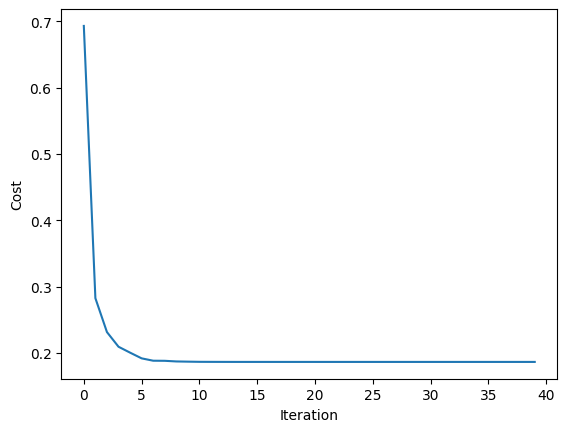

In [58]:
print('Long: 22022604')
pd.Series(training_summary.objectiveHistory).plot()
plt.xlabel("Iteration")
plt.ylabel("Cost")

Find area under the curve. Closer to 1 is better

In [59]:
print('Long: 22022604')
training_summary.areaUnderROC

Long: 22022604


24/10/31 01:45:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


0.9998914836987379

In [60]:
predictions = lr_model.transform(testing).withColumn("match", expr("prediction == sentiment_idx"))

In [61]:
print('Long: 22022604')
predictions.select("prediction", "sentiment_idx", "sentiment", "match").sample(False, 0.01).show(10)

Long: 22022604
+----------+-------------+---------+-----+
|prediction|sentiment_idx|sentiment|match|
+----------+-------------+---------+-----+
|       1.0|          1.0|      pos| true|
|       1.0|          1.0|      pos| true|
|       0.0|          0.0|      neg| true|
|       0.0|          0.0|      neg| true|
|       1.0|          1.0|      pos| true|
|       0.0|          0.0|      neg| true|
|       0.0|          0.0|      neg| true|
|       1.0|          1.0|      pos| true|
|       0.0|          0.0|      neg| true|
|       0.0|          1.0|      pos|false|
+----------+-------------+---------+-----+
only showing top 10 rows



24/10/31 01:45:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [62]:
print('Long: 22022604')
predictions.groupBy("sentiment_idx").pivot("prediction").count().show()

Long: 22022604


24/10/31 01:45:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:10 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


+-------------+----+----+
|sentiment_idx| 0.0| 1.0|
+-------------+----+----+
|          0.0|6592| 936|
|          1.0| 674|6740|
+-------------+----+----+



24/10/31 01:45:10 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


Find the accuracy of the prediction

In [63]:
print('Long: 22022604')
accuracy = predictions.select(expr("sum(cast(match as int))")).first()[0] / predictions.count()
accuracy

Long: 22022604


24/10/31 01:45:10 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/31 01:45:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


0.8922500334627226